In [1]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

import pandas as pd

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 20}) #make plots more readable

import palettable as pal

import MagellanicStream as ms

import mass_calc as mc #field mass
import field_area_calculation as ac #field area

import dlnpyutils as dlpu

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

In [2]:
#calculate absolute mag
def absmag(magnitude,distance):
    '''
    - magnitude: apparent magnitude of star
    - distance: distance to star in kpc
    Calculate the absolute magnitude of star
    '''
    absm = []
    absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
    absm = np.squeeze(np.array(absm))
    return absm

######################################
### Get Cartesian Coordinates (MC) ### 
######################################

def LMCdisk_cart(ra, dec):
    
    '''
    Calculate the position of stars in the LMC disk plane with 
    center at the LMC center in cartesian coordinates (x, y).
    This also calculates the distance to the individual stars.
    
    This follows van der Marel and Cioni 2001 
    
    Input
    - ra: right ascension of stars
    - dec: declination of stars
    
    Output
    - x_m: x coordinate
    - y_m: y coordinate
    - dis: distance to LMC star
    '''
    alph0 = np.radians(82.25) #right ascension of center of LMC
    delt0 = np.radians(-69.50) #declination of center of LMC
    pa = np.radians(149.23+90.00) #146.37 #position angle of line of nodes
    io = np.radians(25.86) #27.81 #inclination of LMC disk
    d0 = 49.90 #distance to center of LMC
    
    #convert to radians
    ra = np.radians(ra)
    dec = np.radians(dec)
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    
    cr = cd*np.cos(dec)*np.cos(ra-alph0)+sd*np.sin(dec)
    srcp = -np.cos(dec)*np.sin(ra-alph0)
    srsp = cd*np.sin(dec) - sd*np.cos(dec)*np.cos(ra-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cr - np.sin(io)*np.cos(pa)*srsp + np.sin(io)*np.sin(pa)*srcp)
    
    x_m = dis*srcp
    y_m = dis*(np.cos(io)*srsp + np.sin(io)*cr) - d0*np.sin(io)
    
    return x_m, y_m, dis


def sal(MH,aM):
    '''
    Calculate the Salaris correction to the overall metallicity
    '''
    return MH + np.log(0.638*(10**(aM))+0.362)

def mad(dat):
    '''
    Calculate the median absolute deviation of 1d array-like object dat
    '''
    return np.median(np.absolute(dat - np.median(dat)))

In [3]:
###Code to Convert to MS coordinates
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product, matrix_transpose
import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates import SkyCoord

class MagellanicStream(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the Magellanic Stream
    Parameters
    ----------
    representation : `BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)
    MSLongitude : `Angle`, optional, must be keyword
        The longitude-like angle corresponding to the Magellanic Stream.
    MSLatitude : `Angle`, optional, must be keyword
        The latitude-like angle corresponding to the Magellanic Stream.
    distance : `Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.
    pm_Lambda_cosBeta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion along the Stream in ``Lambda`` (including the
        ``cos(Beta)`` factor) for this object (``pm_Beta`` must also be given).
    pm_Beta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in Declination for this object (``pm_ra_cosdec`` must
        also be given).
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The radial velocity of this object.
    """
    default_representation = coord.SphericalRepresentation
    #default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'MSLongitude'),
            coord.RepresentationMapping('lat', 'MSLatitude'),
            coord.RepresentationMapping('distance', 'distance')]#,
        #coord.SphericalCosLatDifferential: [
        #    coord.RepresentationMapping('d_lon_coslat', 'pm_lon_coslat'),
        #    coord.RepresentationMapping('d_lat', 'pm_lat'),
        #    coord.RepresentationMapping('d_distance', 'radial_velocity')],
        #coord.SphericalDifferential: [
        #    coord.RepresentationMapping('d_lon', 'pm_lon'),
        #    coord.RepresentationMapping('d_lat', 'pm_lat'),
        #   coord.RepresentationMapping('d_distance', 'radial_velocity')]
    }

    frame_specific_representation_info[coord.UnitSphericalRepresentation] = \
        frame_specific_representation_info[coord.SphericalRepresentation]
    #frame_specific_representation_info[coord.UnitSphericalCosLatDifferential] = \
    #    frame_specific_representation_info[coord.SphericalCosLatDifferential]
    #frame_specific_representation_info[coord.UnitSphericalDifferential] = \
    #    frame_specific_representation_info[coord.SphericalDifferential]


MS_PHI = (180 + 8.5 + 90) * u.degree # Euler angles (from Nidever 2010)
MS_THETA = (90 + 7.5) * u.degree
MS_PSI = -32.724214217871349 * u.degree  # anode parameter from gal2mag.pro

D = rotation_matrix(MS_PHI, "z")
C = rotation_matrix(MS_THETA, "x")
B = rotation_matrix(MS_PSI, "z")
A = np.diag([1., 1., 1.])
MS_MATRIX = matrix_product(A, B, C, D)

@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.Galactic, MagellanicStream)
def galactic_to_MS():
    """ Compute the transformation matrix from Galactic spherical to
        Magellanic Stream coordinates.
    """
    return MS_MATRIX

@frame_transform_graph.transform(coord.StaticMatrixTransform, MagellanicStream, coord.Galactic)
def MS_to_galactic():
    """ Compute the transformation matrix from Magellanic Stream coordinates to
        spherical Galactic.
    """
    return matrix_transpose(MS_MATRIX)

###Actual coordinate transform from previous cell
#c_icrs = SkyCoord(ra=tmp.ra.data*u.degree, dec=tmp.dec.data*u.degree)
#c_ms = c_icrs.transform_to(MagellanicStream)
#ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

In [4]:
#parsec
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Structure/logisochrones.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

#DR16 r13
lmcdr16 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Structure/lmc_rgbmembers_r13-l33-58672.fits.gz',1)
clnr = np.where((lmcdr16['FE_H']>-9999.0)&(lmcdr16['AK_TARG']>-9999.0)&(lmcdr16['LOGG']>0.0)&\
                (lmcdr16['M_H_ERR']>-90.0)&(lmcdr16['C_FE']>-9999.0)&(lmcdr16['N_FE']>-9999.0))

clndr16 = lmcdr16[clnr]

#Transform ra and dec to L and B
c_icrs = SkyCoord(ra=clndr16['RA']*u.degree, dec=clndr16['DEC']*u.degree)
c_ms = c_icrs.transform_to(MagellanicStream)
ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

for i in range(len(ms_lg)):
    if ms_lg[i] - 360 < -180:
        ms_lg[i] += 360.0

In [5]:
def parsec_age(w,x,y,z):
    p=[28.90025823,-0.8303683,3.28088688,-0.08771859,-7.48008086,-0.66424502,\
       0.04407313,0.13976222,0.74247359]
    return p[0]+p[1]*w+p[2]*x+p[3]*y+p[4]*z+p[5]*np.multiply(x,z)+p[6]*np.multiply(y,z)+p[7]*(x**2)+p[8]*(z**2)

In [6]:
######################
### Calculate Ages ###
######################

abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(clndr16)):
    x_C.append(sol_xm[0]*10**(clndr16['C_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_N.append(sol_xm[1]*10**(clndr16['N_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_O.append(sol_xm[2]*10**(clndr16['O_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Mg.append(sol_xm[3]*10**(clndr16['Mg_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Ca.append(sol_xm[4]*10**(clndr16['Ca_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_S.append(sol_xm[5]*10**(clndr16['S_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Si.append(sol_xm[6]*10**(clndr16['SI_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Fe.append(sol_xm[7]*10**(clndr16['FE_H']-clndr16['M_H']))
    
facts = []
factsalp = []
factsCNO = []
factsCN = []
factsCO = []
for j in range(len(clndr16)):
    numerCN = x_C[j]+x_N[j]
    denomCN = sum(sol_xm[0:2])
    
    numerCO = x_C[j]+x_O[j]
    denomCO = sol_xm[0]+sol_xm[2]
factsCN.append(numerCN/denomCN)
factsCO.append(numerCO/denomCO)
    
# factsCN = factsCN[0]
# factsCO = factsCO[0]

metscorr = np.log10(0.638*(np.asarray(factsCN)+0.362))

x_cart,y_cart, stardist = LMCdisk_cart(clndr16['RA'],clndr16['DEC'])
corabsK = absmag(clndr16['K'],stardist)-clndr16['AK_TARG']
parage = parsec_age(np.log10(clndr16['TEFF']),corabsK,sal(clndr16['M_H'],metscorr),clndr16['LOGG'])
parage = np.squeeze(parage)

In [7]:
####################################
### Get Uncertainties: Add Noise ###
####################################

'''in alpha w/o C and N, out alpha w/ C and N'''

def noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,fehERR,lgg,lggERR):
    carbon = 0.28115244582676185 # derived in initial age calc
    nitrogen = 0.06901474154376043 # derived in initial age calc
    Tnoise = np.random.normal(0, 0.434*(lgTERR/lgT)) #logTeff
    Knoise = np.random.normal(0, ksERR) #Ks
    MHnoise = np.random.normal(0, mhERR) #[M/H]
    
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    
    expcarERR = 10**(cm)*np.log(10)*CMERR
    expnitERR = 10**(nm)*np.log(10)*NMERR
    
    xcarb = carbon*10**(cm)
    xnitr = nitrogen*10**(nm)
    fac = (xcarb+xnitr)/(carbon+nitrogen) #factor from Salaris correction
    facERR = np.sqrt((expcarERR)**2+(expnitERR)**2)/(carbon+nitrogen)
    
    facnoise = np.random.normal(0, np.absolute(0.434*(facERR/fac)))
    
    lggnoise = np.random.normal(0, lggERR) #logg
    Tnew = lgT + ((-1)**np.random.randint(2))*Tnoise
    Knew = ks + ((-1)**np.random.randint(2))*Knoise
    MHnew = mh + ((-1)**np.random.randint(2))*MHnoise
    facnew = fac + ((-1)**np.random.randint(2))*facnoise
    lggnew = lgg + ((-1)**np.random.randint(2))*lggnoise
    return Tnew, Knew, MHnew, facnew, lggnew

In [8]:
######################################
### Get Uncertainties: Calc Uncert ###
######################################

devs = []

for i in tqdm_notebook(range(len(clndr16)),desc='Done?'):
    lgT = np.log10(clndr16['TEFF'][i])
    lgTERR = 0.434*(np.log(clndr16['TEFF_ERR'][i])/np.log10(clndr16['TEFF'][i]))
    ks = corabsK[i]
    ksERR = clndr16['K_ERR'][i]
    mh = clndr16['M_H'][i]
    mhERR = clndr16['M_H_ERR'][i]
    cfe = clndr16['C_FE'][i]
    cfeERR = clndr16['C_FE_ERR'][i]
    nfe = clndr16['N_FE'][i]
    nfeERR = clndr16['N_FE_ERR'][i]
    feh = clndr16['FE_H'][i]
    fehERR = clndr16['FE_H_ERR'][i]
    lgg = clndr16['LOGG'][i]
    lggERR = clndr16['LOGG_ERR'][i]
    
    ages = []
    for j in range(1000):
        nlgT,nks,nmh,nfac,nlgg = noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,\
                                          fehERR,lgg,lggERR)
        ages.append(parsec_age(nlgT,nks,sal(nmh,nfac),nlgg))
    
    devs.append(mad(ages))

In [13]:
young = np.where(parage<=np.log10(3.5*10**9))
ymed = np.where((parage>np.log10(3.5*10**9))&(parage<=np.log10(7*10**9)))
omed = np.where((parage>np.log10(7*10**9))&(parage<=np.log10(10.5*10**9)))
old = np.where(parage>np.log10(10.5*10**9))

In [77]:
#######################
### Pick out Fields ###
#######################

absH = absmag(clndr16['H'],stardist)-clndr16['AK_TARG']

dor30 = np.where(clndr16['FIELD']=='30Dor')
lmc1 = np.where(clndr16['FIELD']=='LMC1')
lmc2 = np.where(clndr16['FIELD']=='LMC2')
lmc3 = np.where(clndr16['FIELD']=='LMC3')
lmc4 = np.where(clndr16['FIELD']=='LMC4')
lmc5 = np.where(clndr16['FIELD']=='LMC5')
lmc6 = np.where(clndr16['FIELD']=='LMC6')
lmc7 = np.where(clndr16['FIELD']=='LMC7')
lmc8 = np.where(clndr16['FIELD']=='LMC8')
lmc9 = np.where(clndr16['FIELD']=='LMC9')
lmc10 = np.where(clndr16['FIELD']=='LMC10')
lmc11 = np.where(clndr16['FIELD']=='LMC11')
lmc12 = np.where(clndr16['FIELD']=='LMC12')
lmc13 = np.where(clndr16['FIELD']=='LMC13')
lmc14 = np.where(clndr16['FIELD']=='LMC14')
lmc16 = np.where(clndr16['FIELD']=='LMC16')
lmc17 = np.where(clndr16['FIELD']=='LMC17')

fnt1 = np.where(clndr16[lmc1]['TARGET_NAME']=='FntRGB')
fnt2 = np.where(clndr16[lmc2]['TARGET_NAME']=='FntRGB')
fnt3 = np.where(clndr16[lmc3]['TARGET_NAME']=='FntRGB')
fnt7 = np.where(clndr16[lmc7]['TARGET_NAME']=='FntRGB')
fnt10 = np.where(clndr16[lmc10]['TARGET_NAME']=='FntRGB')
fnt11 = np.where(clndr16[lmc11]['TARGET_NAME']=='FntRGB')
fnt12 = np.where(clndr16[lmc12]['TARGET_NAME']=='FntRGB')
fnt16 = np.where(clndr16[lmc16]['TARGET_NAME']=='FntRGB')
fnt17 = np.where(clndr16[lmc17]['TARGET_NAME']=='FntRGB')

brt1 = np.where(clndr16[lmc1]['TARGET_NAME']=='BrtRGB')
brt2 = np.where(clndr16[lmc2]['TARGET_NAME']=='BrtRGB')
brt3 = np.where(clndr16[lmc3]['TARGET_NAME']=='BrtRGB')
brt7 = np.where(clndr16[lmc7]['TARGET_NAME']=='BrtRGB')
brt10 = np.where(clndr16[lmc10]['TARGET_NAME']=='BrtRGB')
brt11 = np.where(clndr16[lmc11]['TARGET_NAME']=='BrtRGB')
brt12 = np.where(clndr16[lmc12]['TARGET_NAME']=='BrtRGB')
brt16 = np.where(clndr16[lmc16]['TARGET_NAME']=='BrtRGB')
brt17 = np.where(clndr16[lmc17]['TARGET_NAME']=='BrtRGB')

### single fields H mags
dor30lo = np.where(absH[dor30]==np.min(absH[dor30]))
dor30hi = np.where(absH[dor30]==np.max(absH[dor30]))
lmc4lo = np.where(absH[lmc4]==np.min(absH[lmc4]))
lmc4hi = np.where(absH[lmc4]==np.max(absH[lmc4]))
lmc5lo = np.where(absH[lmc5]==np.min(absH[lmc5]))
lmc5hi = np.where(absH[lmc4]==np.max(absH[lmc5]))
lmc6lo = np.where(absH[lmc6]==np.min(absH[lmc6]))
lmc6hi = np.where(absH[lmc6]==np.max(absH[lmc6]))
lmc8lo = np.where(absH[lmc8]==np.min(absH[lmc8]))
lmc8hi = np.where(absH[lmc8]==np.max(absH[lmc8]))
lmc9lo = np.where(absH[lmc9]==np.min(absH[lmc9]))
lmc9hi = np.where(absH[lmc9]==np.max(absH[lmc9]))
lmc13lo = np.where(absH[lmc13]==np.min(absH[lmc13]))
lmc13hi = np.where(absH[lmc13]==np.max(absH[lmc13]))
lmc14lo = np.where(absH[lmc14]==np.min(absH[lmc14]))
lmc14hi = np.where(absH[lmc14]==np.max(absH[lmc14]))

dor30Hpar = np.where((parsec['Hmag']<=absH[dor30][dor30hi])&(parsec['Hmag']>=absH[dor30][dor30lo]))
lmc4Hpar = np.where((parsec['Hmag']<=absH[lmc4][lmc4hi])&(parsec['Hmag']>=absH[lmc4][lmc4lo]))
lmc5Hpar = np.where((parsec['Hmag']<=absH[lmc5][lmc5hi])&(parsec['Hmag']>=absH[lmc5][lmc5lo]))
lmc6Hpar = np.where((parsec['Hmag']<=absH[lmc6][lmc6hi])&(parsec['Hmag']>=absH[lmc6][lmc6lo]))
lmc8Hpar = np.where((parsec['Hmag']<=absH[lmc8][lmc8hi])&(parsec['Hmag']>=absH[lmc8][lmc8lo]))
lmc9Hpar = np.where((parsec['Hmag']<=absH[lmc9][lmc9hi])&(parsec['Hmag']>=absH[lmc9][lmc9lo]))
lmc13Hpar = np.where((parsec['Hmag']<=absH[lmc13][lmc13hi])&(parsec['Hmag']>=absH[lmc13][lmc13lo]))
lmc14Hpar = np.where((parsec['Hmag']<=absH[lmc14][lmc14hi])&(parsec['Hmag']>=absH[lmc14][lmc14lo]))

### double fields brt H mags
blmc1lo = np.where(absH[lmc1][brt1]==np.min(absH[lmc1][brt1]))
blmc1hi = np.where(absH[lmc1][brt1]==np.max(absH[lmc1][brt1]))
blmc2lo = np.where(absH[lmc2][brt2]==np.min(absH[lmc2][brt2]))
blmc2hi = np.where(absH[lmc2][brt2]==np.max(absH[lmc2][brt2]))
blmc3lo = np.where(absH[lmc3][brt3]==np.min(absH[lmc3][brt1]))
blmc3hi = np.where(absH[lmc3][brt3]==np.max(absH[lmc3][brt1]))
blmc7lo = np.where(absH[lmc7][brt7]==np.min(absH[lmc7][brt7]))
blmc7hi = np.where(absH[lmc7][brt7]==np.max(absH[lmc7][brt7]))
blmc10lo = np.where(absH[lmc10][brt10]==np.min(absH[lmc10][brt10]))
blmc10hi = np.where(absH[lmc10][brt10]==np.max(absH[lmc10][brt10]))
blmc11lo = np.where(absH[lmc11][brt11]==np.min(absH[lmc11][brt11]))
blmc11hi = np.where(absH[lmc11][brt11]==np.max(absH[lmc11][brt11]))
blmc12lo = np.where(absH[lmc12][brt12]==np.min(absH[lmc12][brt12]))
blmc12hi = np.where(absH[lmc12][brt12]==np.max(absH[lmc12][brt12]))
blmc16lo = np.where(absH[lmc16][brt16]==np.min(absH[lmc16][brt16]))
blmc16hi = np.where(absH[lmc16][brt16]==np.max(absH[lmc16][brt16]))
blmc17lo = np.where(absH[lmc17][brt17]==np.min(absH[lmc17][brt17]))
blmc17hi = np.where(absH[lmc17][brt17]==np.max(absH[lmc17][brt17]))

blmc1Hpar = np.where((parsec['Hmag']<=absH[lmc1][blmc1hi])&(parsec['Hmag']>=absH[lmc1][blmc1lo]))
blmc2Hpar = np.where((parsec['Hmag']<=absH[lmc2][blmc2hi])&(parsec['Hmag']>=absH[lmc2][blmc2lo]))
blmc3Hpar = np.where((parsec['Hmag']<=absH[lmc3][blmc3hi])&(parsec['Hmag']>=absH[lmc3][blmc3lo]))
blmc7Hpar = np.where((parsec['Hmag']<=absH[lmc7][blmc7hi])&(parsec['Hmag']>=absH[lmc7][blmc7lo]))
blmc10Hpar = np.where((parsec['Hmag']<=absH[lmc10][blmc10hi])&(parsec['Hmag']>=absH[lmc10][blmc10lo]))
blmc11Hpar = np.where((parsec['Hmag']<=absH[lmc11][blmc11hi])&(parsec['Hmag']>=absH[lmc11][blmc11lo]))
blmc12Hpar = np.where((parsec['Hmag']<=absH[lmc12][blmc12hi])&(parsec['Hmag']>=absH[lmc12][blmc12lo]))
blmc16Hpar = np.where((parsec['Hmag']<=absH[lmc16][blmc16hi])&(parsec['Hmag']>=absH[lmc16][blmc16lo]))
blmc17Hpar = np.where((parsec['Hmag']<=absH[lmc17][blmc17hi])&(parsec['Hmag']>=absH[lmc17][blmc17lo]))

### double fields fnt H mags
flmc1lo = np.where(absH[lmc1][fnt1]==np.min(absH[lmc1][fnt1]))
flmc1hi = np.where(absH[lmc1][fnt1]==np.max(absH[lmc1][fnt1]))
flmc2lo = np.where(absH[lmc2][fnt2]==np.min(absH[lmc2][fnt2]))
flmc2hi = np.where(absH[lmc2][fnt2]==np.max(absH[lmc2][fnt2]))
flmc3lo = np.where(absH[lmc3][fnt3]==np.min(absH[lmc3][fnt1]))
flmc3hi = np.where(absH[lmc3][fnt3]==np.max(absH[lmc3][fnt1]))
flmc7lo = np.where(absH[lmc7][fnt7]==np.min(absH[lmc7][fnt7]))
flmc7hi = np.where(absH[lmc7][fnt7]==np.max(absH[lmc7][fnt7]))
flmc10lo = np.where(absH[lmc10][fnt10]==np.min(absH[lmc10][fnt10]))
flmc10hi = np.where(absH[lmc10][fnt10]==np.max(absH[lmc10][fnt10]))
flmc11lo = np.where(absH[lmc11][fnt11]==np.min(absH[lmc11][fnt11]))
flmc11hi = np.where(absH[lmc11][fnt11]==np.max(absH[lmc11][fnt11]))
flmc12lo = np.where(absH[lmc12][fnt12]==np.min(absH[lmc12][fnt12]))
flmc12hi = np.where(absH[lmc12][fnt12]==np.max(absH[lmc12][fnt12]))
flmc16lo = np.where(absH[lmc16][fnt16]==np.min(absH[lmc16][fnt16]))
flmc16hi = np.where(absH[lmc16][fnt16]==np.max(absH[lmc16][fnt16]))
flmc17lo = np.where(absH[lmc17][fnt17]==np.min(absH[lmc17][fnt17]))
flmc17hi = np.where(absH[lmc17][fnt17]==np.max(absH[lmc17][fnt17]))

flmc1Hpar = np.where((parsec['Hmag']<=absH[lmc1][flmc1hi])&(parsec['Hmag']>=absH[lmc1][flmc1lo]))
flmc2Hpar = np.where((parsec['Hmag']<=absH[lmc2][flmc2hi])&(parsec['Hmag']>=absH[lmc2][flmc2lo]))
flmc3Hpar = np.where((parsec['Hmag']<=absH[lmc3][flmc3hi])&(parsec['Hmag']>=absH[lmc3][flmc3lo]))
flmc7Hpar = np.where((parsec['Hmag']<=absH[lmc7][flmc7hi])&(parsec['Hmag']>=absH[lmc7][flmc7lo]))
flmc10Hpar = np.where((parsec['Hmag']<=absH[lmc10][flmc10hi])&(parsec['Hmag']>=absH[lmc10][flmc10lo]))
flmc11Hpar = np.where((parsec['Hmag']<=absH[lmc11][flmc11hi])&(parsec['Hmag']>=absH[lmc11][flmc11lo]))
flmc12Hpar = np.where((parsec['Hmag']<=absH[lmc12][flmc12hi])&(parsec['Hmag']>=absH[lmc12][flmc12lo]))
flmc16Hpar = np.where((parsec['Hmag']<=absH[lmc16][flmc16hi])&(parsec['Hmag']>=absH[lmc16][flmc16lo]))
flmc17Hpar = np.where((parsec['Hmag']<=absH[lmc17][flmc17hi])&(parsec['Hmag']>=absH[lmc17][flmc17lo]))

In [89]:
flmc7Hpar

(array([], dtype=int64),)

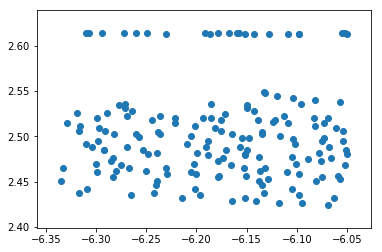

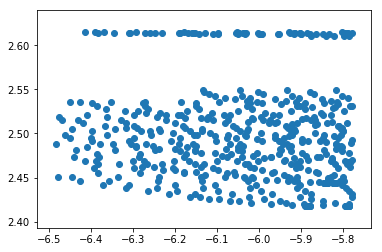

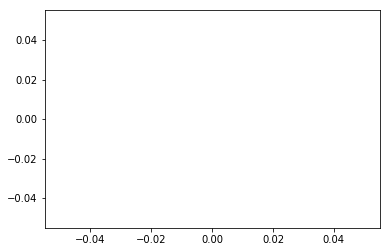

In [88]:
plt.scatter(parsec['Hmag'][dor30Hpar],parsec['int_IMF'][dor30Hpar])
plt.show()
plt.scatter(parsec['Hmag'][lmc4Hpar],parsec['int_IMF'][lmc4Hpar])
plt.show()

plt.scatter(parsec['Hmag'][flmc7Hpar],parsec['int_IMF'][flmc7Hpar])
plt.scatter(parsec['Hmag'][blmc7Hpar],parsec['int_IMF'][blmc7Hpar])
plt.show()

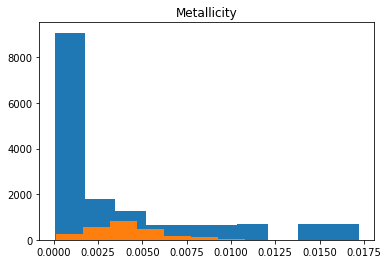

In [65]:
plt.hist(parsec['Zini'],label='Parsec')
plt.hist(0.02*10**(clndr16['FE_H']),label='APOGEE')
plt.title('Metallicity')
plt.show()

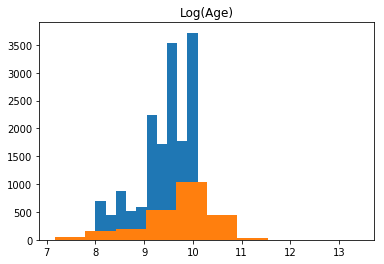

In [69]:
plt.hist(parsec['logAge'],label='Parsec')
plt.hist(parage,label='APOGEE')
plt.title('Log(Age)')
plt.show()

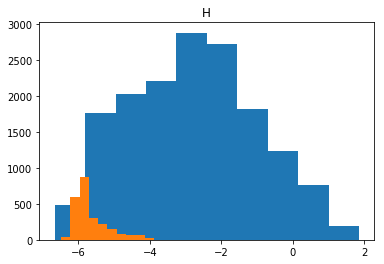

In [70]:
plt.hist(parsec['Hmag'],label='Parsec')
plt.hist(absH,label='APOGEE')
plt.title('H')
plt.show()

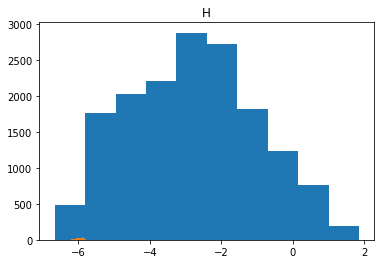

In [81]:
plt.hist(parsec['Hmag'],label='Parsec')
plt.hist(absH[lmc5],label='APOGEE')
plt.title('H')
plt.show()

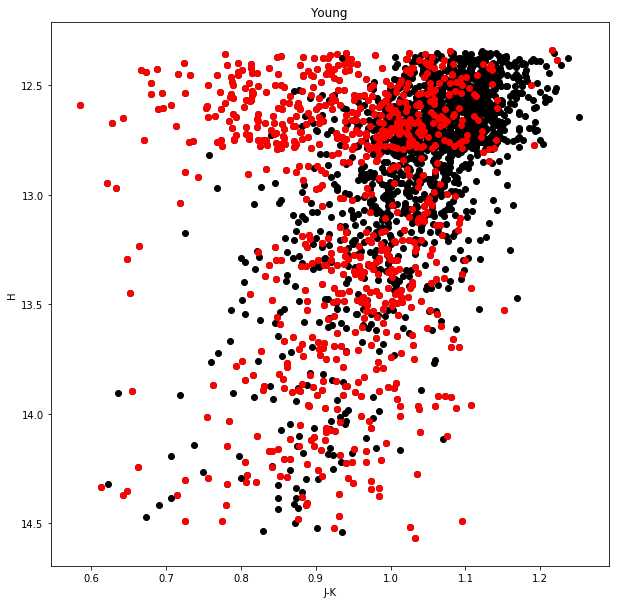

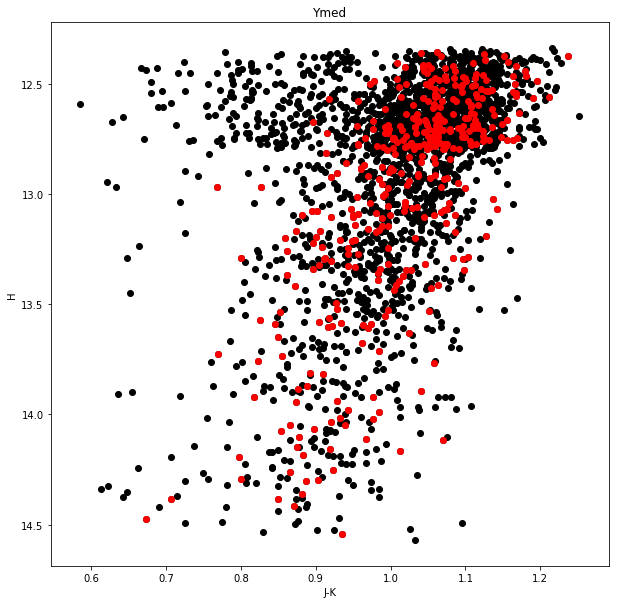

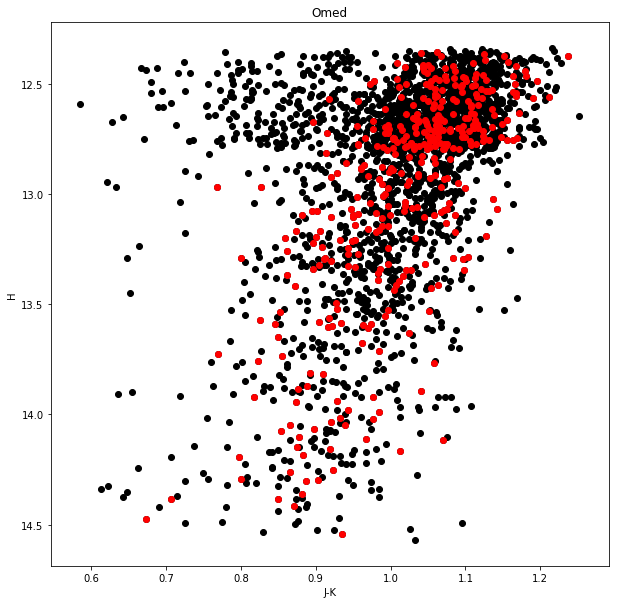

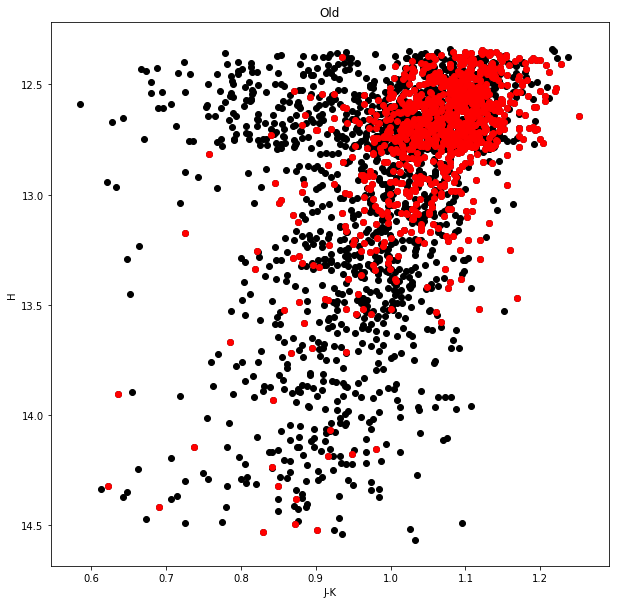

In [14]:
plt.figure(figsize=[10,10])
plt.scatter((clndr16['J']-clndr16['K']),clndr16['H'],color='k')
plt.scatter((clndr16['J']-clndr16['K'])[young],clndr16['H'][young],color='r')
plt.gca().invert_yaxis()
plt.xlabel('J-K')
plt.title(r'Young')
plt.ylabel('H')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter((clndr16['J']-clndr16['K']),clndr16['H'],color='k')
plt.scatter((clndr16['J']-clndr16['K'])[ymed],clndr16['H'][ymed],color='r')
plt.gca().invert_yaxis()
plt.xlabel('J-K')
plt.title(r'Ymed')
plt.ylabel('H')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter((clndr16['J']-clndr16['K']),clndr16['H'],color='k')
plt.scatter((clndr16['J']-clndr16['K'])[ymed],clndr16['H'][ymed],color='r')
plt.gca().invert_yaxis()
plt.xlabel('J-K')
plt.title(r'Omed')
plt.ylabel('H')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter((clndr16['J']-clndr16['K']),clndr16['H'],color='k')
plt.scatter((clndr16['J']-clndr16['K'])[old],clndr16['H'][old],color='r')
plt.gca().invert_yaxis()
plt.xlabel('J-K')
plt.title(r'Old')
plt.ylabel('H')
plt.show()

In [ ]:
f, ax = plt.subplots(2,4, facecolor='w',sharex = True, figsize=(30,15))
ax[0,0].scatter()